In [137]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
from nltk.stem import SnowballStemmer
nltk.download('punkt')
stemmer = SnowballStemmer('portuguese')
import re
from unidecode import unidecode
from keras.regularizers import l2
from gensim.models import KeyedVectors
from tensorflow.keras import layers
from tensorflow.keras.losses import categorical_crossentropy
from keras.layers import Dense, Dropout, LSTM

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/augusto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/augusto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Pipeline 

In [138]:
# Base original da B2W, sem cortes + clean de overall_rating
b2wCorpus = pd.read_csv("B2W-Reviews01.csv",";",usecols=['review_text','overall_rating'])

# Filtro
d = b2wCorpus.index[b2wCorpus["overall_rating"] < 1].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
d = b2wCorpus.index[b2wCorpus["overall_rating"] > 5].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])

print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  Estou contente com a compra entrega rápida o ú...
1                    4  Por apenas R$1994.20,eu consegui comprar esse ...
2                    4  SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3                    4  MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4                    5  A entrega foi no prazo, as americanas estão de...
...                ...                                                ...
132368               5  Vale muito, estou usando no controle do Xbox e...
132369               5  Prático e barato, super indico o produto para ...
132370               4  Chegou antes do prazo previsto e corresponde a...
132371               1  Material fraco, poderia ser melhor. Ficou deve...
132372               1  Comprei esse produto, quando chegou estava com...

[132373 rows x 2 columns]>


In [139]:
# Cleanning function
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
  text = unidecode(text)
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  text = re.sub("\d+", "", text)
  text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [140]:
# Cleanning exec
b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: preprocess(x))

In [141]:
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  contente compra entrega rapida unico problema ...
1                    4        apenas consegui comprar lindo copo acrilico
2                    4  supera agilidade praticidade outras panelas el...
3                    4          filho amou parece verdade tantos detalhes
4                    5  entrega prazo americanas estao parabens smart ...
...                ...                                                ...
132368               5  vale usando controle xbox durou semana carga p...
132369               5  pratico barato super indico produto corre dia ...
132370               4    chegou antes prazo previsto corresponde anuncio
132371               1  material fraco poderia ser melhor ficou devend...
132372               1  comprei produto chegou avaria devolvi ja vai f...

[132373 rows x 2 columns]>


In [142]:
b2wCorpus.overall_rating .value_counts().sort_index()

1    27369
2     8389
3    16315
4    32345
5    47955
Name: overall_rating, dtype: int64

In [143]:
# Partilha
b2wCorpus = b2wCorpus.sample(frac=1).reset_index(drop=True)
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    3  bom produto facil montagem entrega bem rapida ...
1                    1  realizei pedido prazo entrega dias uteis nisso...
2                    4       excelente produto atendeu todas expectativas
3                    5      funciona bem silencioso otimo custo beneficio
4                    3  marreta poderes misticos voa ninguem consegue ...
...                ...                                                ...
132368               5  qualidade simplicidade instalacao uso sao dife...
132369               1  preciso noticias mercadoria pois paguei nunca ...
132370               5  gostei otimo desempenho facil usar design boni...
132371               3  sr recebi produto presteza seguranca infelizme...
132372               1  infelizmente comigo nao funcionou acredito ser...

[132373 rows x 2 columns]>


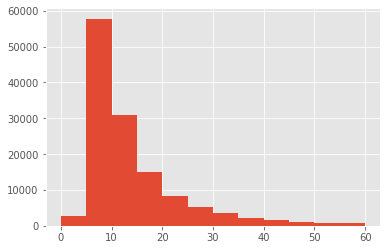

130344


In [144]:
# histograma de palavras x qtd de linhas
Words = [len(linha.split()) for linha in b2wCorpus["review_text"] if len(linha.split()) <=60 ]
plt.style.use('ggplot')
plt.hist(Words, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60])
plt.show()
print(len(Words))

In [145]:
# Codifica
N =  200001
with open("cbow_s50.txt", "r",encoding='utf-8') as file:
    head = [next(file) for x in range(N)]

head[0] = str(N-1)+ " " + "50"+ "\n" # Conserta contagem de palavras
with open("word2vec_200k.txt", "w",encoding='utf-8') as file:
    for line in head:
        file.write(line)

def vocaIndex(lista, stem=False):
    for indice in range(len(lista)):
        text=lista[indice].lower()
        if text in model.vocab:
             lista[indice] = model.vocab[text].index
        else: 
             lista[indice] = '0'
    return lista

model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')

def codifica(text, stem=False):
    tokens = nltk.word_tokenize(text)
    tokens = vocaIndex(tokens)
    return tokens

b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: codifica(x))

In [146]:
b2wCorpus['ord'] = b2wCorpus.apply(lambda row: len(row.review_text), axis=1)

In [147]:
b2wCorpus.shape

(132373, 3)

In [148]:
#b2wCorpus = b2wCorpus[b2wCorpus.ord != 0]
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord < 10].index)
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord > 50].index)

In [149]:
b2wCorpus['overall_rating'] = b2wCorpus.overall_rating.apply(lambda x: x - 1)

In [150]:
b2wCorpus.shape

(68406, 3)

In [151]:
b2wCorpus.reset_index(drop=True, inplace=True)

In [152]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,2,"[226, 902, 54465, 5117, 2499, 70, 85324, 70, 1...",34
1,0,"[58469, 600, 566, 2499, 173, 144754, 2319, 127...",19
2,2,"[49582, 1740, 0, 18141, 31021, 1538, 0, 43404,...",23
3,3,"[18874, 265, 63210, 230, 10570, 321, 2409, 226...",13
4,0,"[4177, 30284, 9735, 902, 12967, 151, 239, 2638...",11


In [153]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [154]:
#b2wCorpus.review_text.str.rjust(width=50, fillchar='0')
#np.reshape(y_train,(-1))

b2wCorpus.review_text = keras.preprocessing.sequence.pad_sequences(b2wCorpus.apply(lambda row: np.reshape(row.review_text,(-1)), axis=1), maxlen=50, padding='post').tolist()

In [155]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,2,"[226, 902, 54465, 5117, 2499, 70, 85324, 70, 1...",34
1,0,"[58469, 600, 566, 2499, 173, 144754, 2319, 127...",19
2,2,"[49582, 1740, 0, 18141, 31021, 1538, 0, 43404,...",23
3,3,"[18874, 265, 63210, 230, 10570, 321, 2409, 226...",13
4,0,"[4177, 30284, 9735, 902, 12967, 151, 239, 2638...",11


In [156]:
# Função de split
def train_validate_test_split(df, train_percent=.65, validate_percent=.1, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [157]:
b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

In [158]:
b2wCorpusTrain=b2wCorpusTrain.reindex(b2wCorpusTrain['ord'].sort_values(ascending=False).index)
b2wCorpusTrain.head()

,overall_rating,review_text,ord
35241,0,"[7256, 12783, 128, 225, 162466, 1299, 6054, 88...",50
703,0,"[1893, 21841, 103, 76, 635, 1912, 2508, 958, 7...",50
39371,3,"[7051, 33125, 45326, 1454, 7497, 13597, 118753...",50
3451,4,"[6376, 902, 0, 191205, 131710, 55606, 0, 0, 0,...",50
2617,0,"[9735, 760, 965, 5301, 5117, 1118, 2566, 27091...",50


In [159]:
#b2wCorpusValidate=b2wCorpusValidate.reindex(b2wCorpusValidate['ord'].sort_values(ascending=False).index)
b2wCorpusValidate.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
35006               0  [902, 7804, 3013, 76, 0, 0, 902, 3013, 0, 1680...   20
12039               3  [201, 3331, 193, 6138, 6034, 388, 0, 1290, 249...   12
1205                1  [2992, 32887, 112, 6341, 15480, 7804, 1593, 11...   11
52717               4  [9735, 47785, 1278, 33424, 5301, 40017, 17382,...   23
55836               0  [168, 9735, 186, 1229, 0, 45058, 3656, 49233, ...   41
...               ...                                                ...  ...
33447               4  [8557, 3690, 978, 0, 532, 1681, 0, 428, 131, 5...   11
41535               3  [101071, 902, 566, 2499, 8089, 26328, 5234, 14...   20
54315               0  [9735, 169, 274, 66523, 331, 254, 7804, 18152,...   44
34120               0  [902, 2773, 2789, 2722, 8567, 2424, 31172, 362...   22
3902                2  [63936, 8215, 45902, 121, 3926, 63700, 96, 362...   10

[6840 rows x 3 columns]>

In [160]:
b2wCorpusTest=b2wCorpusTest.reindex(b2wCorpusTest['ord'].sort_values(ascending=False).index)
b2wCorpusTest.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
62590               4  [2989, 2104, 5841, 26382, 6404, 7958, 6376, 88...   50
20765               4  [331, 21587, 2018, 31839, 21469, 5952, 2625, 1...   50
20169               0  [9735, 902, 86, 112, 578, 2499, 86, 0, 7804, 5...   50
3326                0  [43351, 13151, 439, 9735, 775, 173, 775, 12066...   50
63792               1  [7256, 103, 31760, 30801, 7804, 11936, 70, 780...   50
...               ...                                                ...  ...
20426               4  [532, 7278, 15607, 3690, 153, 167, 0, 1100, 56...   10
30313               4  [12783, 315, 8984, 5785, 929, 110, 1959, 1159,...   10
23238               0  [2420, 45525, 7804, 7341, 2232, 0, 45525, 96, ...   10
55913               4  [24607, 20341, 225, 5437, 3615, 122, 2499, 902...   10
320                 4  [5984, 17525, 0, 596, 29822, 13808, 19610, 161...   10

[17103 rows x 3 columns]>

In [161]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [162]:
# Treino, Validação e teste
RANDOM_SEED = 42
x_train =  [ emb for emb in b2wCorpusTrain.review_text]
y_train =   b2wCorpusTrain.overall_rating
x_val = [ emb for emb in b2wCorpusValidate.review_text ]
y_val = b2wCorpusValidate.overall_rating
x_train = np.asarray(x_train)
x_val =np.asarray(x_val)

np.random.seed(RANDOM_SEED)
model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')
emb = model.get_keras_embedding()

In [ ]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
SEQUENCE_MAXLEN = 50
model = keras.Sequential()
model.add(layers.Input(shape=(SEQUENCE_MAXLEN, )))
model.add(emb)
model.add(keras.layers.LSTM(128, dropout=0.5))
#model.add(Dropout(0.50))
model.add(keras.layers.Dense(5, activation='softmax'))
#opt = tf.keras.optimizers.SGD(learning_rate=.1, momentum=.5)
#opt = tf.keras.optimizers.Adamax(learning_rate=0.01, beta_1=.9, beta_2=.9, epsilon=1e-07, name="Adamax")
#model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['acc', 'mae'])
opt="adam"
model.compile(optimizer=opt,loss=sparse_categorical_crossentropy, metrics=["accuracy"])
history = model.fit(
    x= x_train, y=y_train, batch_size=16, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
2779/2779 [==============================] - 53s 19ms/step - loss: 1.3790 - accuracy: 0.4344 - val_loss: 1.2121 - val_accuracy: 0.5140
Epoch 2/50
2779/2779 [==============================] - 52s 19ms/step - loss: 1.2416 - accuracy: 0.5009 - val_loss: 1.1654 - val_accuracy: 0.5303
Epoch 3/50
2779/2779 [==============================] - 52s 19ms/step - loss: 1.1937 - accuracy: 0.5140 - val_loss: 1.0929 - val_accuracy: 0.5371
Epoch 4/50
2779/2779 [==============================] - 52s 19ms/step - loss: 1.1609 - accuracy: 0.5225 - val_loss: 1.0686 - val_accuracy: 0.5437
Epoch 5/50
2779/2779 [==============================] - 52s 19ms/step - loss: 1.1317 - accuracy: 0.5365 - val_loss: 1.0459 - val_accuracy: 0.5673
Epoch 6/50
2779/2779 [==============================] - 52s 19ms/step - loss: 1.1020 - accuracy: 0.5495 - val_loss: 1.0295 - val_accuracy: 0.5769
Epoch 7/50
2779/2779 [==============================] - 52s 19ms/step - loss: 1.0843 - accuracy: 0.5547 - val_loss: 1.0199 -

In [ ]:
dropout=0.5

In [ ]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show();

In [ ]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show();